In [34]:
from ludwig.utils.data_utils import load_json
from ludwig.visualize import learning_curves
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline

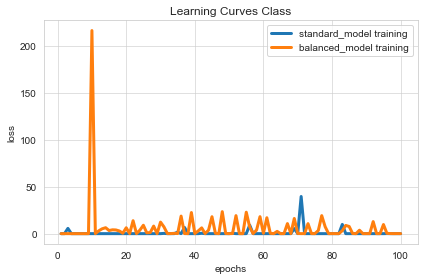

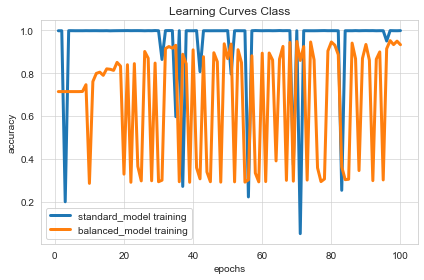

In [8]:
# retrieve training statistics
list_of_stats = []
list_of_models = []

for model in ["standard_model", "balanced_model"]:
    experiment_model_dir = './results/imbalance_experiment_' + model 
    train_stats = load_json(os.path.join(experiment_model_dir,'training_statistics.json'))
    list_of_stats.append(train_stats)
    list_of_models.append(model)
    

# generating learning curves from training
learning_curves(list_of_stats, 'Class',
                model_names=list_of_models,
                output_directory='./visualizations',
                file_format='png')

In [3]:
import logging
import shutil

# Import required libraries
from ludwig.api import LudwigModel
from ludwig.datasets import credit_card_fraud
from ludwig.visualize import learning_curves

In [4]:
training_set = credit_card_fraud.load()

In [5]:
training_set.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [20]:
train, test = train_test_split(training_set, test_size=0.1)

In [28]:
model = LudwigModel(config="balanced_model_config.yaml", backend={"type": "local"})
stats, dataset, output_dir = model.train(train)

/Users/connor/Documents/Projects/predibase/ludwig/ludwig/utils/torch_utils.py:318: UserWarning: PyTorch has already been initialized. Changes to `gpus`, `gpu_memory_limit`, and `allow_parallel_threads` will be ignored. Start a new Python process to modify these values.
  warnings.warn(


Saved checkpoint at /Users/connor/Documents/Projects/predibase/ludwig/examples/class_imbalance/results/api_experiment_run_0/model/training_checkpoints/000000001.ckpt.
Saved checkpoint at /Users/connor/Documents/Projects/predibase/ludwig/examples/class_imbalance/results/api_experiment_run_0/model/training_checkpoints/000000002.ckpt.
Saved checkpoint at /Users/connor/Documents/Projects/predibase/ludwig/examples/class_imbalance/results/api_experiment_run_0/model/training_checkpoints/000000003.ckpt.
Saved checkpoint at /Users/connor/Documents/Projects/predibase/ludwig/examples/class_imbalance/results/api_experiment_run_0/model/training_checkpoints/000000004.ckpt.
Saved checkpoint at /Users/connor/Documents/Projects/predibase/ludwig/examples/class_imbalance/results/api_experiment_run_0/model/training_checkpoints/000000005.ckpt.
Saved checkpoint at /Users/connor/Documents/Projects/predibase/ludwig/examples/class_imbalance/results/api_experiment_run_0/model/training_checkpoints/000000006.ckpt

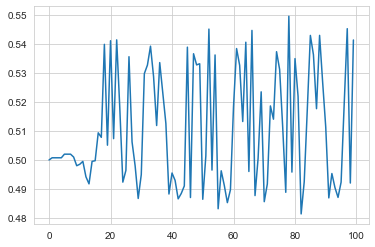

In [38]:
plt.plot(stats['training']['Class']['roc_auc'])

In [23]:
test.Class.value_counts()

0    28431
1       50
Name: Class, dtype: int64

In [14]:
standard_model_stats = list_of_stats[0]

In [15]:
standard_model_stats.keys()

dict_keys(['test', 'training', 'validation'])

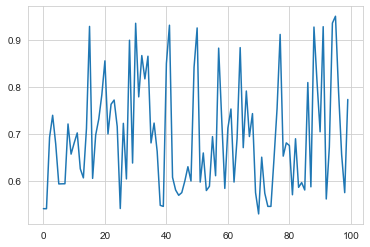

In [16]:
plt.plot(standard_model_stats['training']['Class']['roc_auc'])

In [20]:
standard_model_stats['validation']

{'Class': {'accuracy': [], 'loss': [], 'roc_auc': []},
 'combined': {'loss': []}}

# Generate Annotated Learning Curves Using seaborn package
### Helper function to collect training statistics

In [14]:
# function to generate pandas data frame from training statistcs
# Parameter:
#   experiment_model_dir: directory containing the training statistics for a specific model training experiment
#
# Returns: pandas dataframe containing the performance metric and loss
#

def extract_training_stats(experiment_model_dir):
    list_of_splits = ['training', 'validation', 'test']
    list_of_df = []
    for split in list_of_splits:
        train_stats = load_json(os.path.join(experiment_model_dir,'training_statistics.json'))
        df = pd.DataFrame(train_stats[split]['combined'])
        df.columns = [split + '_' + c for c in df.columns]
        list_of_df.append(df)
        
    df = pd.concat(list_of_df, axis=1)
    df['epoch'] = df.index + 1
        
    return df

### Retrieve training results

In [15]:
standard_model = extract_training_stats('./results/imbalance_experiment_standard_model')
standard_model.name = 'standard_model'
balanced_model = extract_training_stats('./results/imbalance_experiment_balanced_model')
balanced_model.name = 'balanced_model'

In [16]:
standard_model.head()

,training_loss,validation_loss,test_loss,epoch
0,0.182051,NaN,0.166064,1
1,0.313858,NaN,0.287445,2
2,6.172166,NaN,6.160979,3
3,0.034831,NaN,0.031295,4
4,0.060923,NaN,0.056724,5


### Helper function to generate plot ready data

In [17]:
# create pandas dataframe suitable for plotting learning curves
# Parameters
#   train_df_list: list of pandas datatframe containing training statistics
#
# Returns: plot ready pandas dataframe

def create_plot_ready_data(list_of_train_stats_df):
    # holding ready for plot ready data
    plot_ready_list = []
    
    # consolidate the multiple training statistics dataframes
    for df in list_of_train_stats_df:
        for col in ['training', 'validation']:
            df2 = df[['epoch', col + '_loss']].copy()
            df2.columns = ['epoch', 'loss']
            df2['type'] = col
            df2['model'] = df.name
            plot_ready_list.append(df2)

    return pd.concat(plot_ready_list, axis=0, ignore_index=True)

### Plot learning curves

In [18]:
# create plot ready data
learning_curves = create_plot_ready_data([standard_model, balanced_model])

In [19]:
# Plot learning curves for the different models
fig = plt.figure(figsize=(10,6))
sns.set_style(style='dark')
ax = sns.lineplot(x='epoch', y='loss',
             style='type',
             hue='model',
             data=learning_curves)
ax.set_title('Learning Curves', fontdict={'fontsize': 16})

Text(0.5, 1.0, 'Learning Curves')

In [20]:
fig.savefig('./visualizations/custom_learning_curve.png')

In [21]:
fig.show()